# **Implémentez un modèle de scoring**

## Contexte
Le secteur du crédit à la consommation évolue rapidement. Il est nécessaire d'évaluer de manière précise et efficace le risque de crédit.

## Objectif
L'objectif est de calculer la probabilité qu’un client rembourse son crédit et de classer automatiquement les demandes en crédits accordés ou refusés.

## Mission de ce notebook

- Gérer le déséquilibre des classes : Mettre en œuvre des stratégies pour traiter le déséquilibre entre le nombre de bons et de moins bons clients, un aspect crucial pour assurer la précision et l'équité du modèle.
- Évaluer le coût des erreurs : Différencier les coûts entre faux négatifs et faux positifs, conformément aux exigences métier, et intégrer cette considération dans l'évaluation et l'optimisation du modèle.
- Executer la validation croisée et optimiser les hyperparamètres : Utiliser la validation croisée pour garantir la robustesse du modèle et optimiser les hyperparamètres pour améliorer la performance du modèle tout en évitant l'overfitting.
- Analyser les Features Globales et Locales : Explorer l'importance des caractéristiques à l'échelle globale et comprendre comment le modèle prend des décisions à l'échelle individuelle.
- Suivre le Data Drift : Surveiller les changements potentiels dans les données au fil du temps pour maintenir la robustesse du modèle.

## Source
- https://www.kaggle.com/c/home-credit-default-risk/data
- https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Conclusions
- https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [6]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1)

## Importation des bibliothèques

In [7]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import time
import os
import matplotlib.image as img
import requests
import warnings
import io
import missingno as msno
import re
import lightgbm as lgb
import pickle
import joblib
import random

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, auc
from sklearn import metrics 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, RocCurveDisplay  
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, f1_score,  recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display, HTML
from PIL import Image
from io import BytesIO
from typing import List, Tuple
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler




# MLFlow
import mlflow
import mlflow.lightgbm
import mlflow.xgboost
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
from pprint import pprint

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from pprint import pprint

import shap
from shap import LinearExplainer, KernelExplainer, Explanation, TreeExplainer
from shap.maskers import Independent
shap.initjs()

from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from IPython.display import SVG, display

In [8]:
# Afficher les versions des librairies
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

pandas - 2.0.3
numpy - 1.24.3
sklearn - 1.2.2
seaborn - 0.13.0
requests - 2.31.0
missingno - 0.5.2
re - 2.2.1
lightgbm - 4.2.0
joblib - 1.2.0
PIL.Image - 10.0.1
mlflow - 2.10.0
shap - 0.44.0


In [9]:
# definir le nombre maximal de colonnes a afficher
pd.set_option('display.max_columns', None)

# definir la largeur maximale de la colonne
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# palette de couleur des graphiques seaborn
sns.set_palette("pastel")

warnings.filterwarnings('ignore')

## Chargement des données

In [10]:
df_train = pd.read_csv("df_train_preprocessing.csv")
df_test = pd.read_csv("df_test_preprocessing.csv")

In [11]:
df_train.value_counts()

Unnamed: 0  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  LANDAREA_AVG  LIVINGAREA_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  LANDAREA_MODE  LIVINGAREA_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  

In [12]:
df_train.columns.tolist()

['Unnamed: 0',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES

## Séparation des données

In [13]:
df_train

Unnamed: 0  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                0    1.00         0.00          0.00             0.00   
1                1    0.00         1.00          0.00             1.00   
2                2    0.00         0.00          1.00             0.00   
3                3    0.00         1.00          0.00             0.00   
4                4    0.00         0.00          0.00             0.00   
...            ...     ...          ...           ...              ...   
307502      307506    0.00         0.00          0.00             1.00   
307503      307507    0.00         1.00          0.00             0.00   
307504      307508    0.00         1.00          0.00             0.00   
307505      307509    1.00         1.00          0.00             0.00   
307506      307510    0.00         1.00          0.00             1.00   

        CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  \
0               0.00        202,500.00   406,597.50    24,700.50   
1               0.00        270,000.00 1,293,502.50    35,698.50   
2               0.00         67,500.00   135,000.00     6,750.00   
3               0.00        135,000.00   312,682.50    29,686.50   
4               0.00        121,500.00   513,000.00    21,865.50   
...              ...               ...          ...          ...   
307502          0.00        157,500.00   254,700.00    27,558.00   
307503          0.00         72,000.00   269,550.00    12,001.50   
307504          0.00        153,000.00   677,664.00    29,979.00   
307505          0.00        171,000.00   370,107.00    20,205.00   
307506          0.00        157,500.00   675,000.00    49,117.50   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            351,000.00                        0.02   -9,461.00   
1          1,129,500.00                        0.00  -16,765.00   
2            135,000.00                        0.01  -19,046.00   
3            297,000.00                        0.01  -19,005.00   
4            513,000.00                        0.03  -19,932.00   
...                 ...                         ...         ...   
307502       225,000.00                        0.03   -9,327.00   
307503       225,000.00                        0.03  -20,775.00   
307504       585,000.00                        0.01  -14,966.00   
307505       319,500.00                        0.01  -11,961.00   
307506       675,000.00                        0.05  -16,856.00   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0             -637.00          -3,648.00        -2,120.00        1.00   
1           -1,188.00          -1,186.00          -291.00        1.00   
2             -225.00          -4,260.00        -2,531.00        1.00   
3           -3,040.00          -9,832.00        -2,437.00        1.00   
4           -3,038.00          -4,312.00        -3,458.00        1.00   
...               ...                ...              ...         ...   
307502        -236.00          -8,456.00        -1,982.00        1.00   
307503      -2,384.14          -4,388.00        -4,090.00        1.00   
307504      -7,920.00          -6,736.00        -5,150.00        1.00   
307505      -4,784.00          -2,562.00          -931.00        1.00   
307506      -1,262.00          -5,128.00          -410.00        1.00   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                 1.00             0.00              1.00        1.00   
1                 1.00             0.00              1.00        1.00   
2                 1.00             1.00              1.00        1.00   
3                 1.00             0.00              1.00        0.00   
4                 1.00             0.00              1.00        0.00   
...                ...              ...               ...         ...   
307502            1.00             0.00              1.00        0.00   
307503            0.00             0

In [14]:
df_sample = df_train.copy()
df_sample = df_sample.sample(n =150000, random_state=42)

In [15]:
X = df_sample.drop(["Unnamed: 0","TARGET", "SK_ID_CURR"], axis=1, errors="ignore")
#X = df_train.drop(["TARGET"], axis=1, errors="ignore")
y = df_sample["TARGET"]

# Spliter 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vérifier la taille des matrices
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120000, 583), (30000, 583), (120000,), (30000,))

In [16]:
X_val, X_val_test, y_val, y_val_test = train_test_split(X_test, y_test, test_size=0.20, stratify=y_test, random_state=42)

# Vérifier la taille des matrices
X_val.shape, X_val_test.shape, y_val.shape, y_val_test.shape

((24000, 583), (6000, 583), (24000,), (6000,))

In [17]:
# Standardiser
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=['float64']).columns
scaler.fit(X_train[num_cols])

X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.transform(X_train[num_cols])

X_val_scaled = X_val.copy()
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])


In [18]:
# Créer un échantillon aléatoire de 1000 lignes pour le jeu de test
X_test_essai = df_train.sample(n=1000, random_state=1)

# Supprimer la colonne 'TARGET' du jeu de test
X_test_essai = X_test_essai.drop(columns=['TARGET'])

# Exclure le jeu de test de l'ensemble d'entraînement
X_train_essai = df_train.drop(X_test_essai.index)

# Créer un échantillon aléatoire de 1000 lignes pour le jeu d'entraînement
X_train_essai = X_train_essai.sample(n=1000, random_state=1)

# Enregistrer les jeux de données dans des fichiers csv
X_test_essai.to_csv('donnees_test_essai.csv', index=False)
X_train_essai.to_csv('donnees_train_essai.csv', index=False)

In [19]:
# API
sample_size = 1000
random.seed(42)  

# Jeu de test 
test_indices = random.sample(df_train.index.tolist(), sample_size)
X_test_api = df_train.loc[test_indices].copy()
X_test_api['SK_ID_CURR'] = X_test_api.index
X_test_api.drop(columns=['TARGET'], inplace=True)

#Exclure le jeu de test de l'ensemble d'entraînement
X_train_api = df_train.drop(test_indices)

# Jeu d'entrainement
train_indices = random.sample(X_train_api.index.tolist(), sample_size)
X_train_api = X_train_api.loc[train_indices].copy()

# Enregistrer
X_test_api.to_csv('test_api.csv', index=False)
X_train_api.to_csv('train_api.csv', index=False)

## Métrique et Score Métier

La problématique métier du projet repose sur la notion que les erreurs de prédiction ne coûtent pas toutes la même chose.
Un faux positif (un bon client considéré comme mauvais) n'a pas le même impact financier qu'un faux négatif (un mauvais client à qui nous accordons un prêt). 

On suppose qu'un faux négatif coûte dix fois plus cher qu'un faux positif.  

Pour tenir compte de cette différence de coût, une métrique de performance sur mesure est crée le "score métier".  

Ce score prend en compte les valeurs de la matrice de confusion du modèle.  

La matrice de confusion donne le nombre de vrais positifs, de vrais négatifs, de faux positifs et de faux négatifs résultant de nos prédictions par rapport à la réalité.  

Les coefficients ont été modifiés comme suit :

TP_coeff (Vrais positifs) = 0
FP_coeff (Faux positifs) = 0 (ce sont les cas où le modèle prédit à tort un défaut)
FN_coeff (Faux négatifs) = -10 (ce sont les cas où le modèle prédit à tort l'absence de défaut, ce qui coûte cher)
TN_coeff (Vrais négatifs) = 1
Le calcul du score métier est effectué en utilisant ces coefficients :

Score = (TP * TP_coeff + TN * TN_coeff + FP * FP_coeff + FN * FN_coeff) / (TN + FP + FN + TP)

L'objectif de ce score métier est d'évaluer la performance du modèle en tenant compte des coûts associés aux différentes erreurs de prédiction. Dans cette version, les faux négatifs sont fortement pénalisés avec un coefficient de -10, mettant ainsi l'accent sur la prévention des faux négatifs pour réduire les coûts financiers associés. 

L'objectif est de minimiser ce score, car un score métier plus bas signifie une reduction du coûts financiers liés aux erreurs de prédiction, en donnant une plus grande importance à la prévention des faux négatifs.  

En parallèle de cette métrique métier :

| Métrique          | Description                                                                                                                                                                              |
|-------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Exactitude (Accuracy) | Évalue la proportion de prédictions justes (vrais positifs et vrais négatifs) par rapport au total des prédictions. Répond à la question : Quel est le pourcentage de prédictions correctes ? |
| Précision (Precision) | Mesure le rapport entre les vrais positifs correctement identifiés et l'ensemble des résultats positifs prédits. Permet de savoir : Parmi les cas prédits positifs, combien le sont réellement ? |
| Rappel (Recall)       | Quantifie la proportion de vrais positifs correctement identifiés par rapport à l'ensemble des cas positifs réels. Vise à minimiser les faux négatifs. Répond à la question : Quelle part des cas positifs réels est correctement identifiée ? |
| Score F1              | Représente la moyenne harmonique entre précision et rappel. Utile pour comparer des modèles avec des taux de précision et de rappel déséquilibrés.                                           |
| Score Fbeta           | Version étendue du score F, intégrant un paramètre ajustable nommé bêta. Bêta par défaut est 1.0. Bêta inférieur (ex. 0.5) accorde plus d'importance à la précision, et bêta supérieur (ex. 2.0) valorise davantage le rappel. |
| Score ROC AUC         | AUC mesure la capacité d'un modèle à distinguer entre les classes. Un score de 1 indique un modèle parfait, un score de 0.5 un modèle non informatif.    


In [20]:
# Calculer une métrique métier en se basant sur la matrice de confusion. 
# avec une pondération aux faux positifs (FP) et aux faux négatifs (FN) pour évaluer la performance.
# hypothese :  le coût d'un faux négatif est dix fois supérieur à celui d'un faux positif.
def calcul_score(y_true, y_pred) :
     
    TP_coeff = 0       # Vrais positifs
    FP_coeff = 0       # Faux positifs (prédit comme faisant défaut (1) mais ne fait pas défaut (0))
    FN_coeff = -10     # Faux négatifs (prédit comme ne faisant pas défaut (0) mais font défaut (1))
    TN_coeff = 1       # Vrais négatifs
    
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_true, y_pred).ravel()
    
    score = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)
    
    return score

In [21]:
def graphe_score(y_pred_proba, y_true, verbose=True):  
    '''Créer un graphique permettant de déterminer le score max en fonction du seuil.
    :param: y_pred_proba (probabilités prédites par le modèle), y_true (valeurs réelles),
    verbose (affiche le graphe ou juste le score maximal)
    :return: graphique, 
    '''
    scores = []
    for seuil  in np.linspace(0, 1, num=101):
        y_pred = np.where(y_pred_proba > seuil , 1, 0)
        score = calcul_score(y_true, y_pred)
        scores.append(score)

    if verbose:
        score_max = max(scores)
        seuil_optimal = np.linspace(0, 1, num=101)[scores.index(score_max)]
        y_pred = np.where(y_pred_proba > seuil_optimal, 1, 0)
        
        display("Score métier maximum : {:.2f}".format(score_max))
        display("Seuil  optimal : {}".format(seuil_optimal))
        
        fig, ax = plt.subplots(figsize=(6, 5))
        plt.plot(np.linspace(0, 1, num=101), scores, label="score du modèle")
        plt.axvline(x=seuil_optimal, color='k', dashes=(0.5, 1), 
                    label="seuil optimal: {}".format(seuil_optimal))
        
        plt.title("Score métier en fonction du seuil", fontsize=10)
        plt.xlabel("Seuils", fontsize=10)
        plt.ylabel("Score métier", fontsize=10)
        plt.legend()
        plt.show()
     
    else:
        return max(scores)
    
# Sauvegarder la courbe ROC en tant que fichier PNG.
def sauvegarder_roc_auc(y_true, y_pred_proba, chemin_fichier='roc_auc.png'):
    """
    Génère et sauvegarde la courbe ROC en tant que fichier PNG.
    
    :param y_true: valeurs réelles (étiquettes/classes).
    :param y_pred_proba: probabilités prédites pour la classe positive.
    :param chemin_fichier: chemin pour sauvegarder le fichier PNG de la courbe ROC.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(chemin_fichier)
    plt.close()   

#  Afficher la matrice de confusion.
def afficher_matrice_confusion(y_true, y_pred, algo_name):
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Nég', 'Faux Pos', 'Faux Nég', 'Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe estimée')
    plt.title('Matrice de confusion ' + algo_name)
    plt.show()
    
    

def val_metrics(model, X_test, y_true, algoname , seuil=0.5):
    '''Calcule, affiche et enregistre les différentes métriques.
    :param: model, X_val (dataframe de validation), y_true (vraies valeurs),
    seuil (seuil de détermination des prédictions)
    :return: affiche (et return) les métriques, la matrice de confusion et la courbe ROC.
    '''    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = np.where(y_pred_proba > seuil, 1, 0)
    
    metier = calcul_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)    
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    fbeta_score = metrics.fbeta_score(y_true, y_pred, beta=2)
    rocauc = metrics.roc_auc_score(y_true, y_pred)
    
    display('Score métier :{:.2f}'.format(metier))
    display('Precision score : {:.2f}'.format(precision))
    display('Recall score : {:.2f}'.format(recall))    
    display('Accuracy score : {:.2f}'.format(accuracy))
    display('F1 score : {:.2f}'.format(f1_score))
    display('Fbeta score : {:.2f}'.format(fbeta_score))
    display('ROC AUC score : {:.2f}'.format(rocauc))   
    
    afficher_matrice_confusion(y_true, y_pred,algoname)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    tx_faux_positifs, tx_vrais_positifs, seuil = metrics.roc_curve(y_true, y_pred_proba)
    roc_auc = metrics.auc(tx_faux_positifs, tx_vrais_positifs)

    plt.title('Courbe ROC')
    plt.plot(tx_faux_positifs, tx_vrais_positifs, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de Vrais Positifs')
    plt.xlabel('Taux de Faux Positifs')
    plt.show()
    
    return metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba

## Rééquilibrage des classes

### Sans rééquilibrage

'Score métier :0.13'

'Precision score : 0.43'

'Recall score : 0.03'

'Accuracy score : 0.92'

'F1 score : 0.05'

'Fbeta score : 0.04'

'ROC AUC score : 0.51'

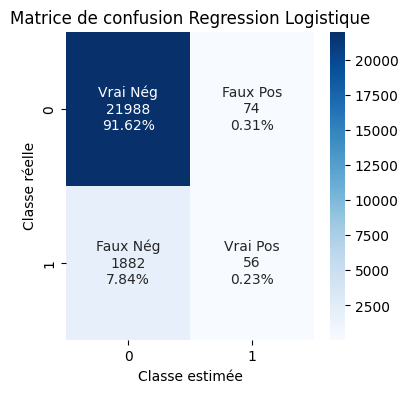

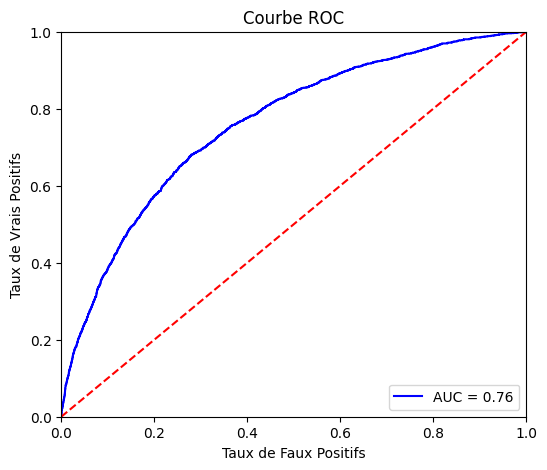

In [22]:
reg_log = LogisticRegression(max_iter=5000,random_state=42)
reg_log.fit(X_train_scaled, y_train)

score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(reg_log,X_val_scaled, y_val, "Regression Logistique")

### Class_weight 

'Score métier :0.40'

'Precision score : 0.17'

'Recall score : 0.69'

'Accuracy score : 0.71'

'F1 score : 0.28'

'Fbeta score : 0.43'

'ROC AUC score : 0.70'

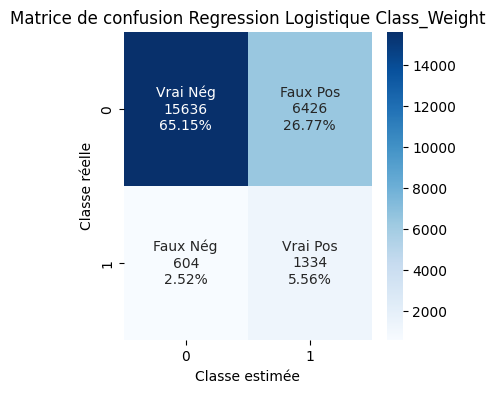

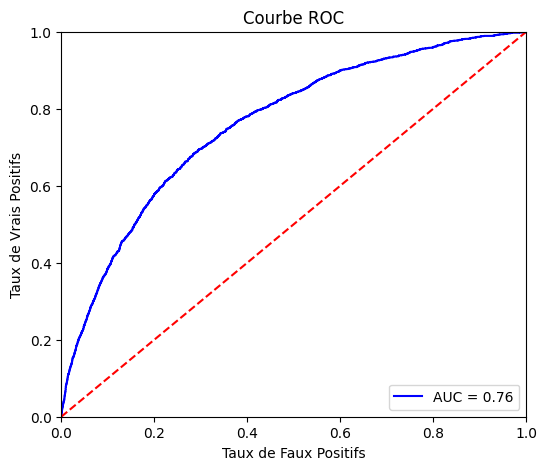

In [23]:
reg_log_weight = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
reg_log_weight.fit(X_train_scaled, y_train)
    
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =val_metrics(reg_log_weight, X_val_scaled, y_val, "Regression Logistique Class_Weight")

### Smote

'Score métier :0.39'

'Precision score : 0.17'

'Recall score : 0.65'

'Accuracy score : 0.72'

'F1 score : 0.27'

'Fbeta score : 0.42'

'ROC AUC score : 0.69'

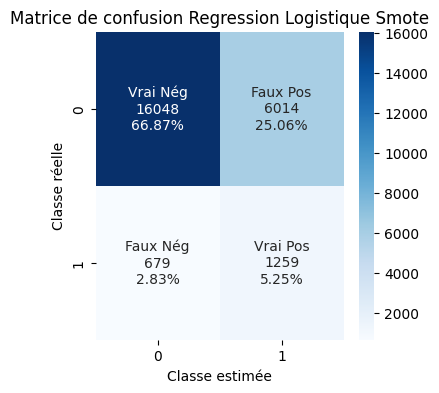

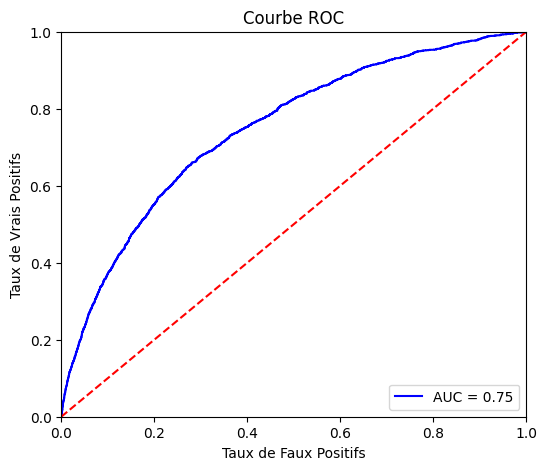

In [24]:
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

reg_log_smote = LogisticRegression(max_iter=1000, random_state=42)
reg_log_smote.fit(X_train_sm, y_train_sm)
    
# Calcul et enregistrement des metriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(reg_log_smote, X_val_scaled, y_val, "Regression Logistique Smote")

### Undersampling

'Score métier :0.39'

'Precision score : 0.17'

'Recall score : 0.69'

'Accuracy score : 0.70'

'F1 score : 0.27'

'Fbeta score : 0.43'

'ROC AUC score : 0.69'

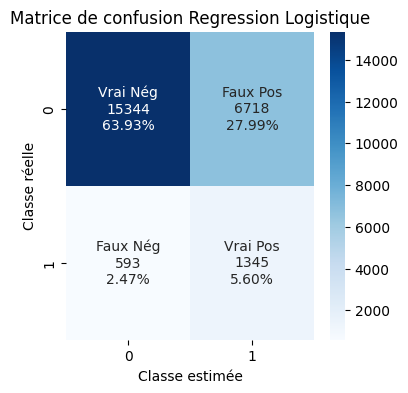

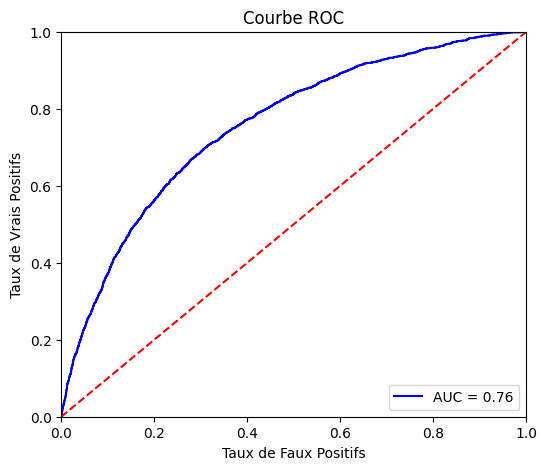

In [25]:
under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train_scaled, y_train)

reg_log_under = LogisticRegression(max_iter=1000, random_state=42)
reg_log_under.fit(X_train_under, y_train_under)

score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(reg_log_under, X_val_scaled, y_val, "Regression Logistique")

In [ ]:
- Après avoir constaté un déséquilibre significatif dans les  données d'entraînement, avec seulement environ 8% des observations appartenant à la classe de défaut de paiement (classe 1) et les 92% restants à la classe de remboursement réussi (classe 0),  différentes stratégies de rééquilibrage sont mises a l'oeuvre.
- Aucun equilibrage
- SMOTE (Synthetic Minority Over-sampling Technique) : une technique de suréchantillonnage qui crée de nouveaux exemples synthétiques de la classe minoritaire en interpolant les exemples existants.
- Undersampling : réduit aléatoirement la taille de la classe majoritaire pour égaliser les effectifs des deux classes.
- class_weight='balanced' : compense le déséquilibre des classes en donnant plus de poids aux classes minoritaires
- Parmi ces stratégies, l'utilisation du paramètre class_weight='balanced' pour le modèle de régression logistique a montré des résultats prometteurs en termes de performances de prédiction par rapport au test sans rééquilibrage.
- class_weight='balanced' sera la stratégie principale  de rééquilibrage les modèles .

# Après avoir constaté un déséquilibre significatif dans nos données d'entraînement, avec seulement environ 8% des observations appartenant à la classe de défaut de paiement (classe 1) et les 92% restants à la classe de remboursement réussi (classe 0), nous avons exploré différentes stratégies de rééquilibrage.

# Les stratégies de rééquilibrage testées comprenaient :
# - Aucun rééquilibrage
# - SMOTE (Synthetic Minority Over-sampling Technique)
# - Undersampling
# - Utilisation de la stratégie de rééquilibrage avec class_weight='balanced' pour le modèle de régression logistique.

# Parmi ces stratégies, l'utilisation de class_weight='balanced' a montré des résultats prometteurs en termes de performances de prédiction par rapport au test sans rééquilibrage. Cette stratégie ajuste automatiquement les poids des différentes classes lors de l'entraînement du modèle, donnant ainsi plus d'importance aux classes moins fréquentes.

# SMOTE (Synthetic Minority Over-sampling Technique) est une technique de suréchantillonnage qui crée de nouveaux exemples synthétiques de la classe minoritaire en interpolant les exemples existants. L'undersampling, quant à lui, consiste à réduire aléatoirement la taille de la classe majoritaire pour égaliser les effectifs des deux classes.

# Finalement, la stratégie class_weight='balanced' sera adoptée comme principale méthode de rééquilibrage pour nos modèles de scoring de crédit, en raison de ses performances prometteuses sur les données déséquilibrées.


## Modélisation 

- **Comparer** : 1 classificateur simple  comme un point de référence de base - DummyClassifier - avec 2 modèles ensemblistes —  LightGBM, Random Forest — reconnus pour leur efficacité sur des données de grandes dimensions et des problématiques similaires à la nôtre,  ainsi qu'un modèle de régression logistique.
- **Utiliser** une grille de recherche avec validation croisée (GridSearchCV) pour optimiser les hyperparamètres et comparer les performances des trois modèles.
- **Prendre en compte** la distribution de la target en utilisant StratifiedKFold pour la cross-validation, afin de construire des folds qui reflètent la distribution des classes dans le jeu de données d'entraînement complet.
- **Mettre en place** un score métier adapté à notre problématique, pour l'évaluation et la comparaison des modèles, tout en choisissant le meilleur modèle et les meilleurs hyperparamètres associés.
- **Maintenir** les métriques techniques comme l’AUC (Area Under the Receiver Operating Characteristic Curve) et l’accuracy pour la comparaison et le contrôle.


### DummyClassifier

#### DummyClassifier sans rééquilibrage

'Score métier :0.11'

'Precision score : 0.00'

'Recall score : 0.00'

'Accuracy score : 0.92'

'F1 score : 0.00'

'Fbeta score : 0.00'

'ROC AUC score : 0.50'

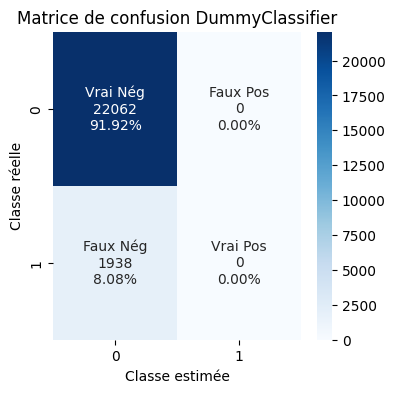

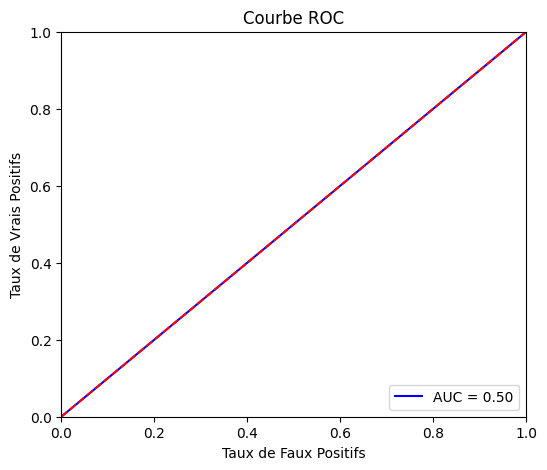

In [26]:
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train_scaled, y_train)
    
# Calcul et enregistrement des metriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
val_metrics(dummy, X_val_scaled, y_val,'DummyClassifier')

'Score métier maximum : 0.11'

'Seuil  optimal : 0.09'

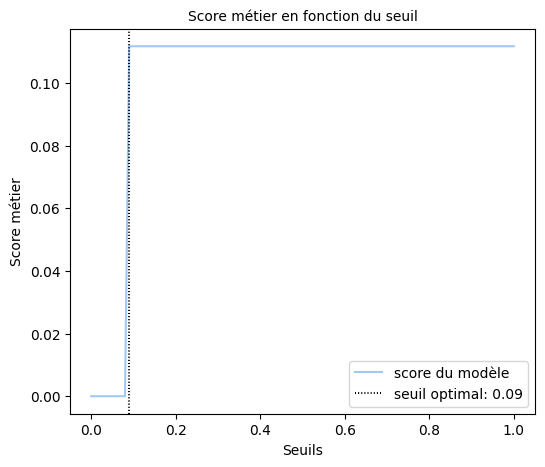

In [27]:
graphe_score(y_pred_proba, y_val, verbose=True)

#### DummyClassifier avec Undersampling

In [28]:
under = RandomUnderSampler()
# Sous-échantillonnage en utilisant RandomUnderSampler
X_train_under, y_train_under = under.fit_resample(X_train_scaled, y_train)

'Score métier :0.11'

'Precision score : 0.00'

'Recall score : 0.00'

'Accuracy score : 0.92'

'F1 score : 0.00'

'Fbeta score : 0.00'

'ROC AUC score : 0.50'

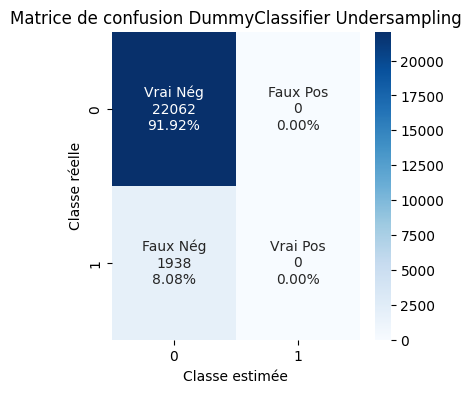

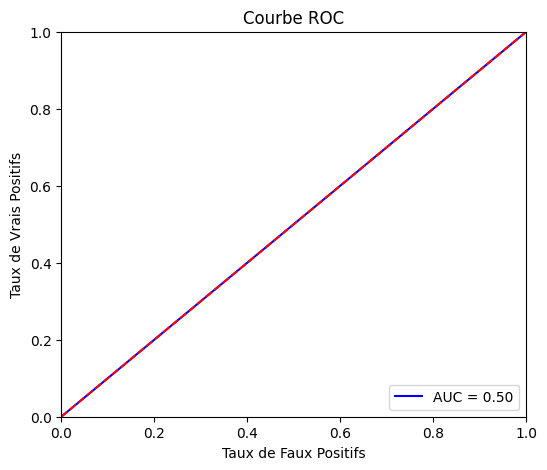

In [29]:
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train_under, y_train_under)
    
# Calcul et enregistrement des metriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
val_metrics(dummy, X_val_scaled, y_val,'DummyClassifier Undersampling')

'Score métier maximum : 0.11'

'Seuil  optimal : 0.5'

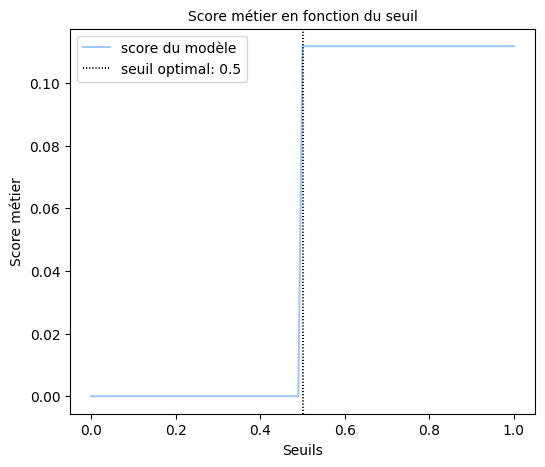

In [30]:
graphe_score(y_pred_proba, y_val, verbose=True)

- Le Dummy Classifier prédit principalement la classe des clients sans défaut, ce qui entraîne un grand nombre de faux négatifs.
- Le score métier du modèle est de 0.11.
- Les scores de précision, rappel, F1 et Fbeta sont tous à 0.00.
- Le score ROC AUC est de 0.50.
- Le seuil optimal identifié pour ce modèle est de 0.5.

- Le modèle classe souvent à tort des clients à risque comme étant sûrs, ce qui baisse son score car on accorde une grande importance à ces erreurs dans notre évaluation.
- Les scores nuls en précision, rappel, F1 et Fbeta suggèrent que le modèle est inefficace pour identifier les cas positifs, car il ne prédit aucune instance positive.
- Un score ROC AUC de 0.50 indique que la performance du modèle est comparable à un choix aléatoire, sans capacité discriminatoire entre les classes.


### RandomForest 

'Score métier :0.11'

'Precision score : 0.17'

'Recall score : 0.00'

'Accuracy score : 0.92'

'F1 score : 0.00'

'Fbeta score : 0.00'

'ROC AUC score : 0.50'

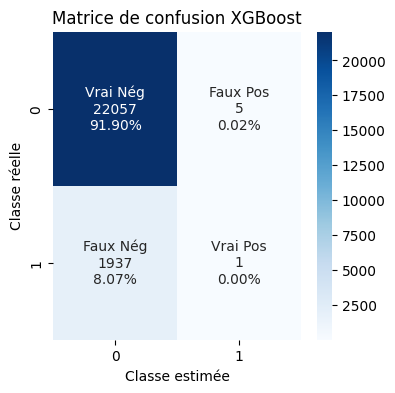

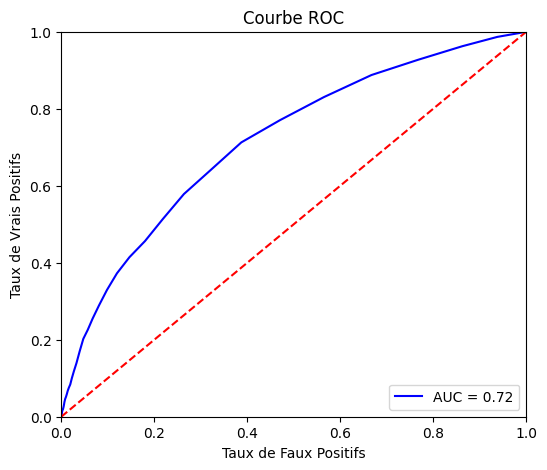

In [31]:
# Création du pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),   
    ('xgb', RandomForestClassifier(random_state=42,class_weight='balanced'))
])

# Ajustement du pipeline sur les données d'entraînement
pipeline_rf.fit(X_train, y_train) 

# Calculer les métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(pipeline_rf, X_val, y_val, 'XGBoost')


'Score métier maximum : 0.34'

'Seuil  optimal : 0.09'

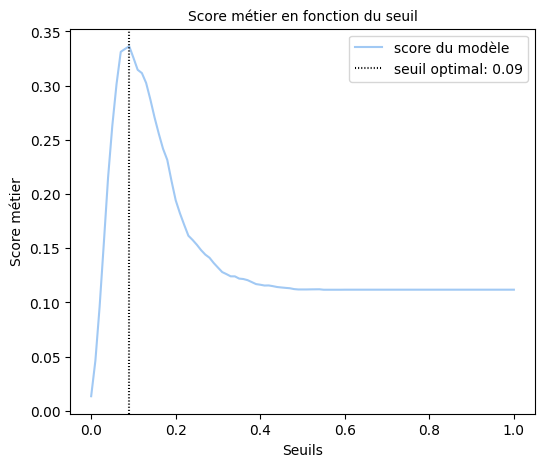

In [32]:
graphe_score(y_pred_proba, y_val, verbose=True)

- Le modèle RandomForest obtient un score métier de 0.11, avec un score métier maximum de 0.34 à un seuil optimal de 0.09.
- Cela ne représente pas d'amélioration par rapport au score de 0.11 du Dummy Classifier, indiquant une moins bonne gestion des faux négatifs.

### Light GBM

[LightGBM] [Info] Number of positive: 9690, number of negative: 110310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.475486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61519
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 552
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


'Score métier :0.41'

'Precision score : 0.19'

'Recall score : 0.65'

'Accuracy score : 0.74'

'F1 score : 0.29'

'Fbeta score : 0.43'

'ROC AUC score : 0.70'

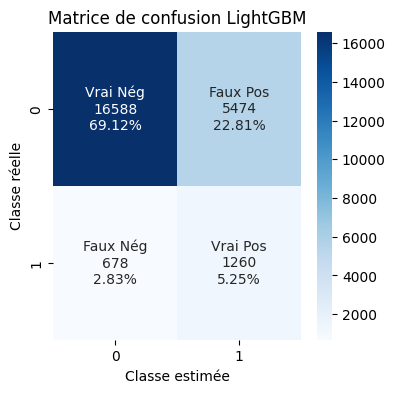

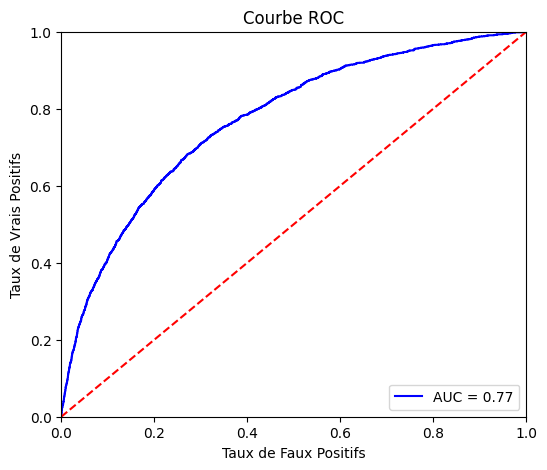

In [33]:
# Creer le pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),   
    ('lgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

# Ajustement du pipeline sur les données d'entraînement
pipeline.fit(X_train, y_train) 

# Calculer les métriques sur les données de validation
score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(pipeline, X_val, y_val, 'LightGBM')


'Score métier maximum : 0.41'

'Seuil  optimal : 0.48'

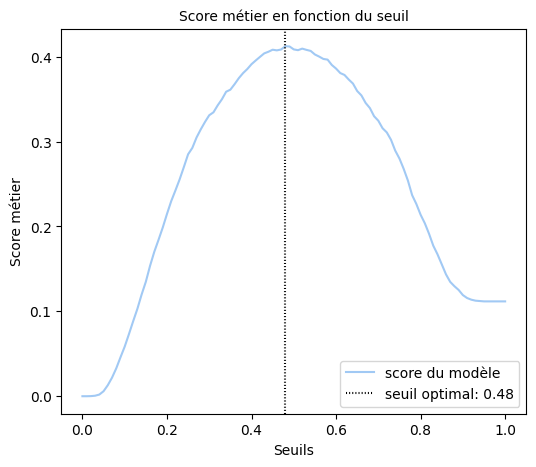

In [34]:
graphe_score(y_pred_proba, y_val, verbose=True)

- Le LightGBM atteint un score métier de 0.41 avec un seuil optimal de 0.48. Cela représente une amélioration par rapport au score du  RandomForest, indiquant une gestion encore plus efficace des faux négatifs.
- Le  Fbeta score de 0.43 suggère une meilleure capacité à identifier correctement les clients à risque (faux négatifs).

## Optimisation des parametres

In [35]:
 algos = {'Régression Logistique': {
              'model': Pipeline([                
                  ('scaler', StandardScaler()),                 
                  ('Logreg', LogisticRegression(solver='lbfgs',
                                                 class_weight='balanced',
                                                 max_iter=10000 , random_state=42))
              ]),
              'params': {
                  'Logreg__penalty': ['l2', 'elasticnet'],
                  'Logreg__C': [10, 100, 1000]
              }
          },
            'Random Forest': {
                'model': Pipeline([                
                    ('scaler', StandardScaler()),
                    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')) 
                    ]),
                'params': {
                      'rf__n_estimators': [50, 100],  # Nombre d'arbres dans la forêt
                      'rf__max_depth': [5, 10],  # Profondeur maximale de l'arbre
                      'rf__min_samples_split': [2, 5],  # Nombre minimum d'échantillons requis pour diviser un nœud
                      'rf__min_samples_leaf': [1, 3]  # Nombre minimum d'échantillons requis à un nœud feuille
                }
                    },          
           'LGBMClassifier': {
             'model': Pipeline([         
          ('scaler',StandardScaler()),        
          ('LGBMC',LGBMClassifier(random_state=42, class_weight='balanced'))
         ]),
             'params': {
             'LGBMC__subsample': [0.5, 0.75],
             'LGBMC__reg_lambda': [ 1, 2],
             'LGBMC__colsample_bytree': [ 0.97, 0.99]            
             }
         }   
       }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts


### MLFOW
- MLflow est une plateforme open source qui simplifie le suivi, la gestion et la production de modèles d'apprentissage automatique.
- MLflow gére l'ensemble du cycle de vie de vos modèles, de l'expérimentation initiale à la mise en production, tout en gardant une trace de toutes les étapes intermédiaires et des métriques de performance associées.

In [42]:
experiment = "oc_p7"
mlflow.set_experiment(experiment)

<Experiment: artifact_location='mlflow-artifacts:/545089728028487445', creation_time=1707465945370, experiment_id='545089728028487445', last_update_time=1707465945370, lifecycle_stage='active', name='oc_p7', tags={}>

In [43]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [44]:
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

'--------------'

'Régression Logistique'

'-------------'

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'Logreg__C': 1000, 'Logreg__penalty': 'l2'}

Best parameters: {'Logreg__C': 1000, 'Logreg__penalty': 'l2'}
Results for the best parameters:



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4         146.42         27.19             0.21            0.01   

  param_Logreg__C param_Logreg__penalty  \
4            1000                    l2   

                                         params  split0_test_score  \
4  {'Logreg__C': 1000, 'Logreg__penalty': 'l2'}               0.40   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
4               0.41               0.40               0.42               0.41   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
4             0.41            0.00                1                0.43   

   split1_train_score  split2_train_score  split3_train_score  \
4                0.43                0.43                0.43   

   split4_train_score  mean_train_score  std_train_score  
4                0.43              0.43             0.00

'Score métier :0.40'

'Precision score : 0.17'

'Recall score : 0.69'

'Accuracy score : 0.71'

'F1 score : 0.27'

'Fbeta score : 0.43'

'ROC AUC score : 0.70'

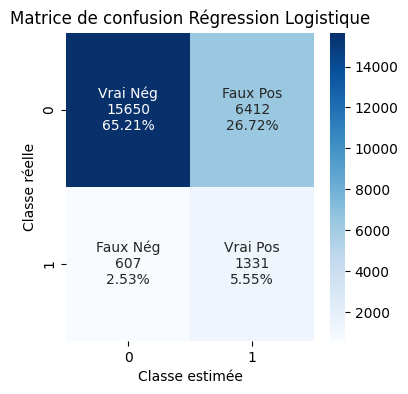

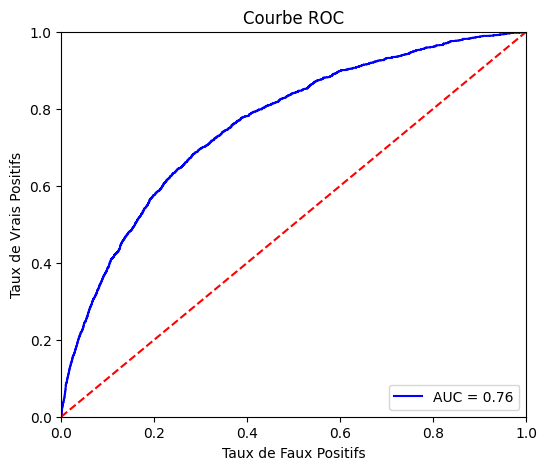

'Score métier maximum : 0.40'

'Seuil  optimal : 0.55'

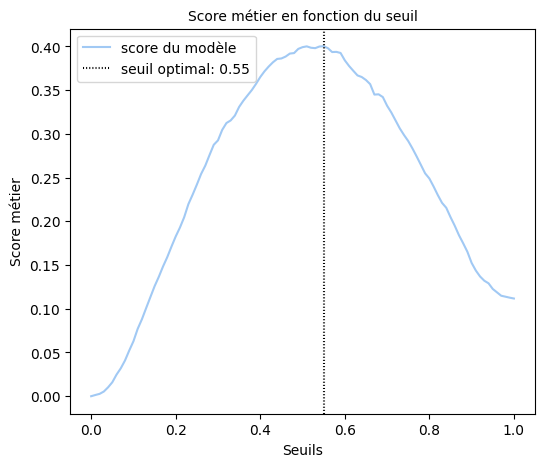

'--------------'

'Random Forest'

'-------------'

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'rf__max_depth': 5,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100}

Best parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Results for the best parameters:



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1          34.03          1.82             0.43            0.12   

  param_rf__max_depth param_rf__min_samples_leaf param_rf__min_samples_split  \
1                   5                          1                           2   

  param_rf__n_estimators  \
1                    100   

                                                                                                 params  \
1  {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1               0.34               0.34               0.35               0.35   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  \
1               0.34             0.35            0.00                1   

   split0_train_score  split1_train_score  split2_train_score  \
1                0.38                0.38                0.39   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
1                0.37                0.38              0.38             0.00

'Score métier :0.34'

'Precision score : 0.15'

'Recall score : 0.63'

'Accuracy score : 0.69'

'F1 score : 0.25'

'Fbeta score : 0.39'

'ROC AUC score : 0.66'

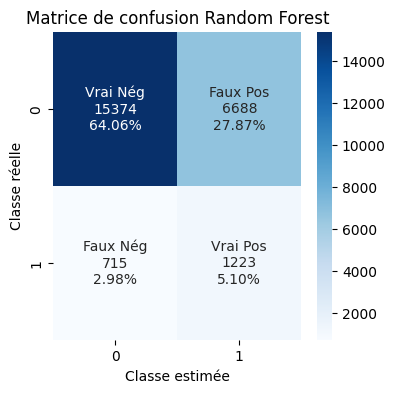

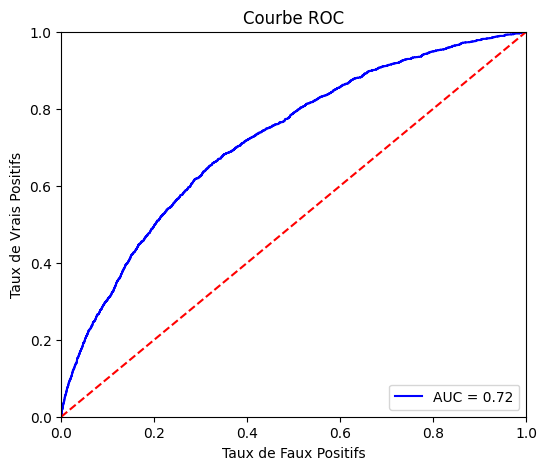

'Score métier maximum : 0.34'

'Seuil  optimal : 0.5'

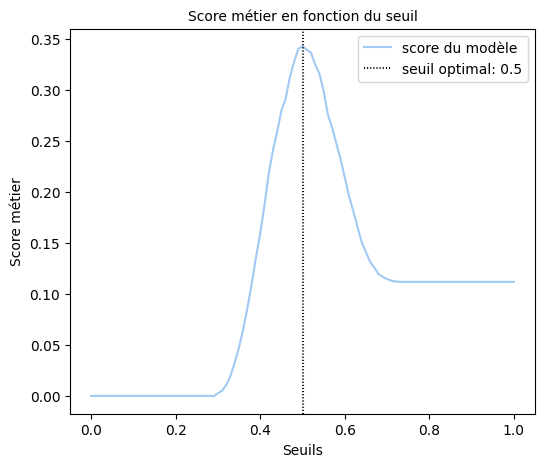

'--------------'

'LGBMClassifier'

'-------------'

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60797
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 551
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.481062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60831
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 551
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.464109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60946
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.487930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60962
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [In

[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.474372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60942
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 7752, number of negative: 88248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.516444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60797
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 551
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [In

{'LGBMC__colsample_bytree': 0.97,
 'LGBMC__reg_lambda': 2,
 'LGBMC__subsample': 0.5}

Best parameters: {'LGBMC__colsample_bytree': 0.97, 'LGBMC__reg_lambda': 2, 'LGBMC__subsample': 0.5}
Results for the best parameters:



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2          19.16          0.63             0.37            0.06   

  param_LGBMC__colsample_bytree param_LGBMC__reg_lambda  \
2                          0.97                       2   

  param_LGBMC__subsample  \
2                   0.50   

                                                                               params  \
2  {'LGBMC__colsample_bytree': 0.97, 'LGBMC__reg_lambda': 2, 'LGBMC__subsample': 0.5}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
2               0.41               0.42               0.40               0.43   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  \
2               0.42             0.42            0.01                1   

   split0_train_score  split1_train_score  split2_train_score  \
2                0.56                0.57                0.57   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
2                0.56                0.57              0.57             0.00

'Score métier :0.42'

'Precision score : 0.19'

'Recall score : 0.66'

'Accuracy score : 0.74'

'F1 score : 0.29'

'Fbeta score : 0.44'

'ROC AUC score : 0.71'

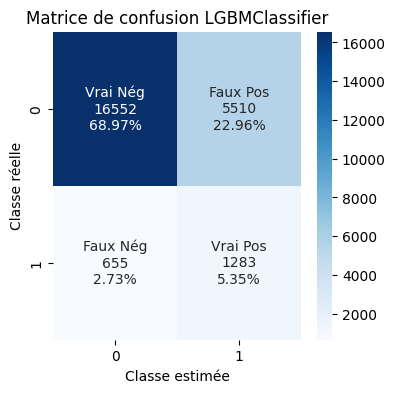

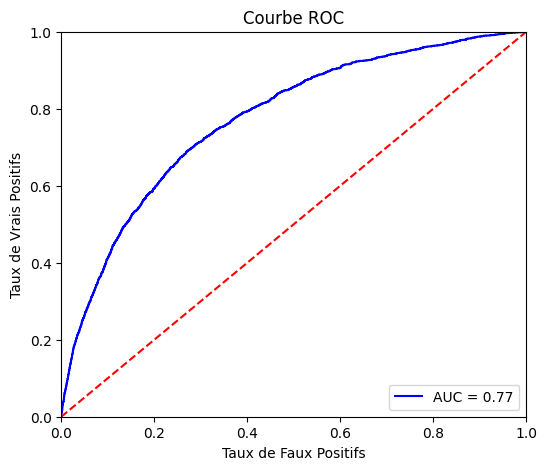

'Score métier maximum : 0.42'

'Seuil  optimal : 0.48'

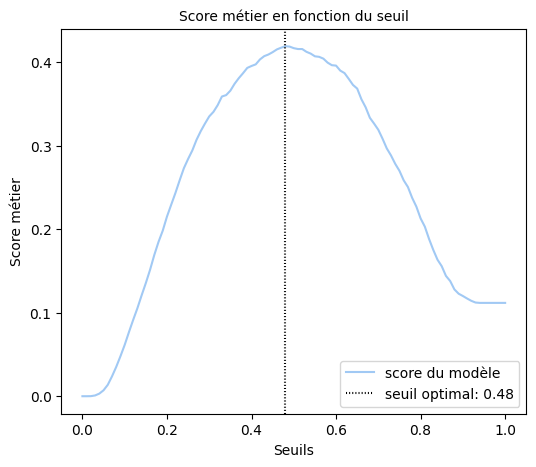

In [45]:
scores = []
best_score = 0

for algo_name, config in algos.items():
    with mlflow.start_run(run_name=algo_name) as run:
        score_metier = make_scorer(calcul_score, greater_is_better=True)
        display ('--------------', algo_name, '-------------')

        gs = GridSearchCV(
                config['model'],
                config['params'],
                cv= cv,
                scoring=score_metier,
                verbose=1,
                return_train_score=True,
                # n_jobs=-1
            )

        gs.fit(X_train, y_train)

        display(gs.best_params_)

        res = pd.DataFrame(gs.cv_results_)

        print('Best parameters:', gs.best_params_)

        res_gs = pd.DataFrame(gs.cv_results_)

        # Display the results for the best parameters
        print("Results for the best parameters:\n")
        display(res_gs.loc[res_gs['params'] == gs.best_params_])

        score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = val_metrics(gs, X_val, y_val, algo_name)
        graphe_score(y_pred_proba, y_val)

        # Sauvegarder best model
        if score_metier > best_score:           
            best_model = gs.best_estimator_
            best_run_id = run.info.run_id
            best_score = score_metier
            joblib.dump(best_model, 'best_model.joblib')
            mlflow.sklearn.log_model(best_model, "model")    
            
        # Calcul du temps d'exécution
        mean_fit_time = gs.cv_results_['mean_fit_time']
        mean_score_time = gs.cv_results_['mean_score_time']
        n_splits = gs.n_splits_
        n_iter = pd.DataFrame(gs.cv_results_).shape[0]

        # Collecter les métriques
        scores.append({
                'Modèle': algo_name,
                'Accuracy': accuracy,
                'AUC': rocauc,           
                'Score métier': score_metier,
                'Temps d\'exécution (minutes)': ((np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter) / 60)
            })
        
        # Sauvagarde courbe roc
        path_fichier = f'roc_auc_{algo_name}.png'
        sauvegarder_roc_auc(y_val, y_pred_proba, path_fichier)
        
        # Créer un dataframe avec les métriques
        results = pd.DataFrame(scores, columns=[
            'Modèle','Accuracy', 'AUC', 'Score métier', 'Temps d\'exécution (minutes)'
        ])
        
        mlflow.log_metric("val_score_métier", score_metier)
        mlflow.log_metric("val_accuracy", accuracy)
        mlflow.log_metric("val_precision", precision)
        mlflow.log_metric("val_recall", recall)
        mlflow.log_metric("val_f1_score", f1_score)
        mlflow.log_metric("val_fbeta_score", fbeta_score)
        mlflow.log_metric("val_rocauc", rocauc)
        mlflow.log_artifact(path_fichier)
        
    # Fin de la session MLflow
    mlflow.end_run()

In [46]:
results

Modèle  Accuracy  AUC  Score métier  \
0  Régression Logistique      0.71 0.70          0.40   
1          Random Forest      0.69 0.66          0.34   
2         LGBMClassifier      0.74 0.71          0.42   

   Temps d'exécution (minutes)  
0                        30.88  
1                        60.02  
2                        13.56

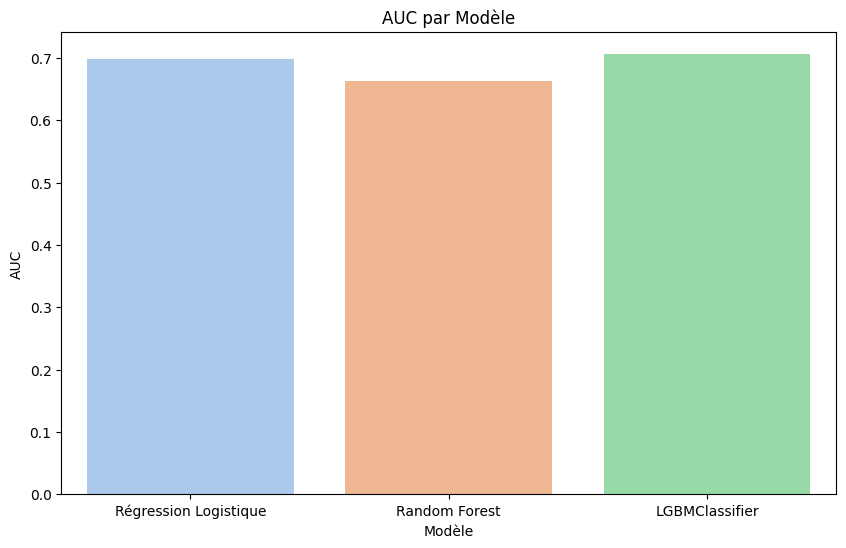

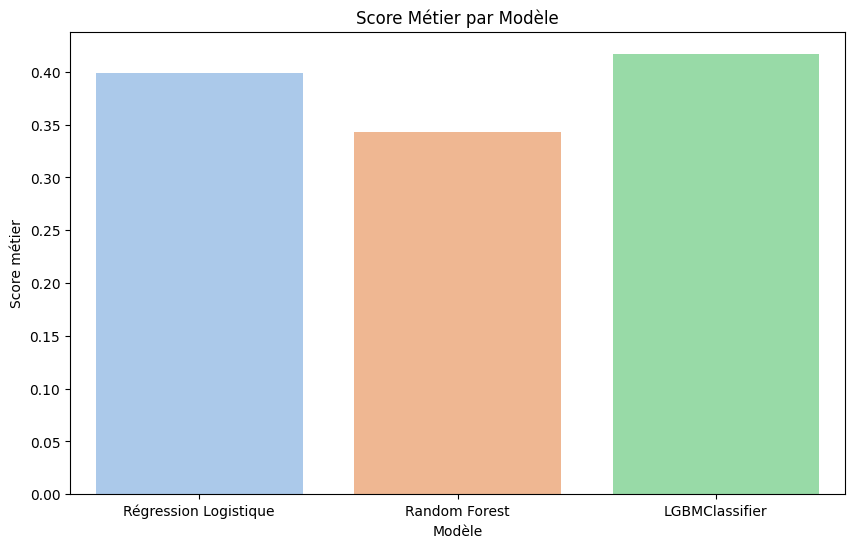

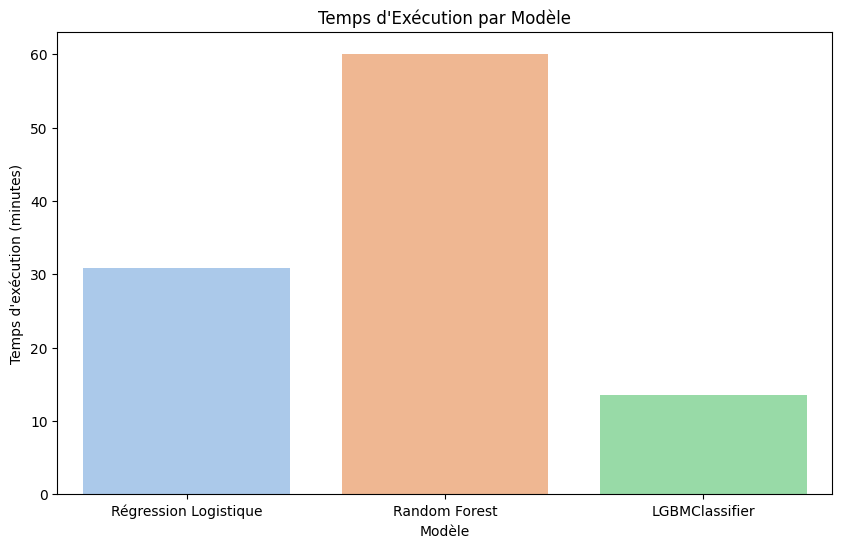

In [47]:
# Graphique pour l'AUC
plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='AUC', data=results, palette='pastel')
plt.title('AUC par Modèle')
plt.show()

# Graphique pour le Score métier
plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='Score métier', data=results, palette='pastel')
plt.title('Score Métier par Modèle')
plt.show()

# Graphique pour le Temps d'exécution
plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='Temps d\'exécution (minutes)', data=results, palette='pastel')
plt.title('Temps d\'Exécution par Modèle')
plt.show()

- LGBMClassifier : Se distingue comme le modèle le plus performant avec un AUC de 71%, accompagnés d'un score métier de 0.42. Notablement, il bénéficie également du temps d'exécution le plus court, soit seulement 13 minutes.
- Le LGBMClassifier émerge comme le modèle le plus performant selon les critères évalués.

### Analyse

In [48]:
logged_model = f'runs:/{best_run_id}/model'
best_model = mlflow.sklearn.load_model(logged_model)

In [49]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('LGBMC',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.97,
                                random_state=42, reg_lambda=2,
                                subsample=0.5))])

In [50]:
model_uri = mlflow.get_run(best_run_id).info.artifact_uri
display(f'Chemin du répertoire de suivi du modèle : {model_uri}')

'Chemin du répertoire de suivi du modèle : mlflow-artifacts:/545089728028487445/a70ce86d2a3d403ab12837bc80c52333/artifacts'

[LightGBM] [Info] Number of positive: 1938, number of negative: 22062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54750
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


'Score métier :0.36'

'Precision score : 0.23'

'Recall score : 0.46'

'Accuracy score : 0.83'

'F1 score : 0.31'

'Fbeta score : 0.39'

'ROC AUC score : 0.66'

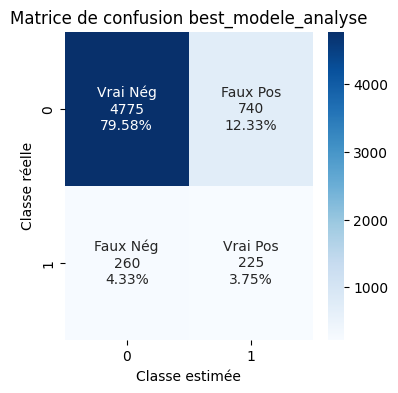

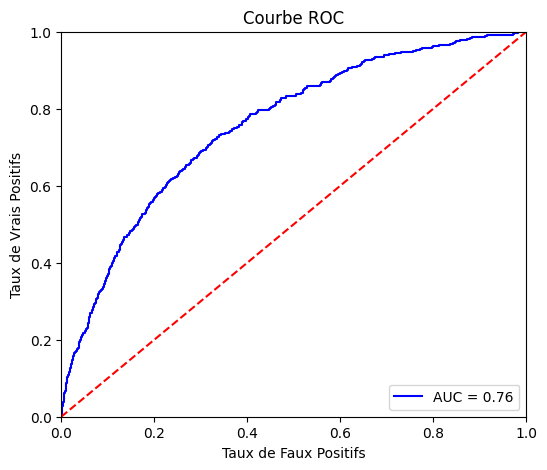

In [51]:
# Extraire les paramètres du meilleur modèle
scaler = best_model.named_steps['scaler']
lgbm_params = best_model.named_steps['LGBMC'].get_params()

pipeline = Pipeline(steps=[
    ('scaler', scaler),    
    ('LGBMC', LGBMClassifier(**lgbm_params))
])

mlflow.lightgbm.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(run_name="ligthgbm_analyse") as run:
    
    pipeline.fit(X_val, y_val)
    val_metrics(pipeline, X_val_test, y_val_test, 'best_modele_analyse', seuil=0.48)
        
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

En examinant le modèle LightGBM à travers ses performances initiales et sur un ensemble de test je constate : 
- Adaptation : La transition d'un AUC de 0.77 à 0.76 montre que le modèle s'adapte bien aux nouvelles données, indiquant une généralisation.
- Surajustement : aide à identifier le risque de surajustement. 
- Pertinence Réelle : Le recul du score métier de 0.42 à 0.36 signifie qu'il faut que le modèle soit non seulement bon en théorie mais aussi utile pour de vrai, dans des situations concrètes.

# Feature importance

- Les valeurs SHAP (SHapley Additive exPlanations) représentent une technique d'interprétation de modèles de machine learning basée sur la théorie des jeux coopératifs. Cette méthode attribue à chaque caractéristique d'un modèle une valeur d'importance qui reflète son impact sur la prédiction.
- L'objectif des valeurs SHAP est double :
- Fournir des Explications Globales : Elles permettent de saisir l'impact général des caractéristiques sur l'ensemble du modèle, offrant ainsi une vision globale de la manière dont les différentes variables influencent les prédictions.
- Offrir des Explications Locales : SHAP propose également une analyse détaillée de prédictions individuelles, en indiquant la contribution spécifique de chaque caractéristique à une prédiction donnée.

## Global

In [52]:
if isinstance(best_model, Pipeline):
    for step_name, step_obj in best_model.named_steps.items():
        print(f"Étape: {step_name}, Type: {type(step_obj).__name__}")


Étape: scaler, Type: StandardScaler
Étape: LGBMC, Type: LGBMClassifier


In [53]:
lgbm_model = best_model.named_steps['LGBMC']

In [54]:
background = Independent(X_val_scaled, max_samples=100)
explainer = TreeExplainer(lgbm_model)
shap_values = explainer(X_val_scaled)
joblib.dump(shap_values, "shap_values.joblib")

['shap_values.joblib']

In [55]:
explainer_pipe = shap.TreeExplainer(lgbm_model)
shap_values_pipe = explainer_pipe.shap_values(X_val_scaled)

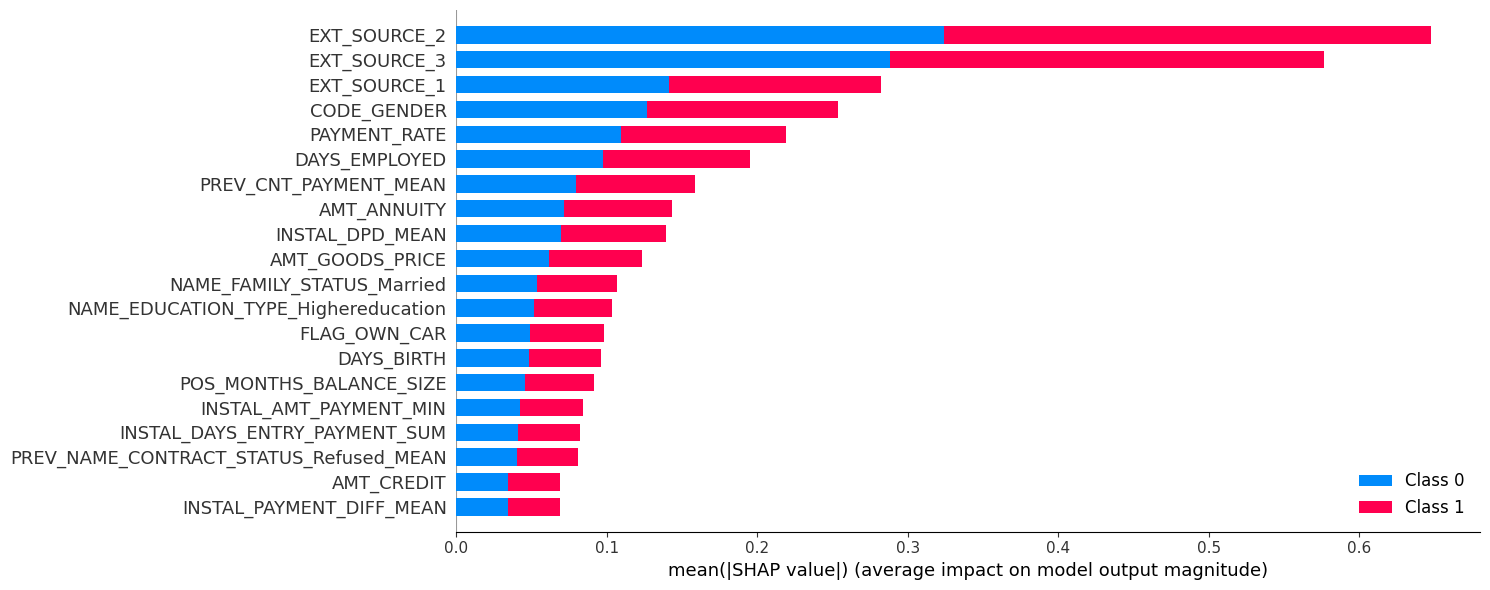

In [56]:
shap.summary_plot(shap_values_pipe, X_val_scaled, plot_type='bar', plot_size=(15,6))

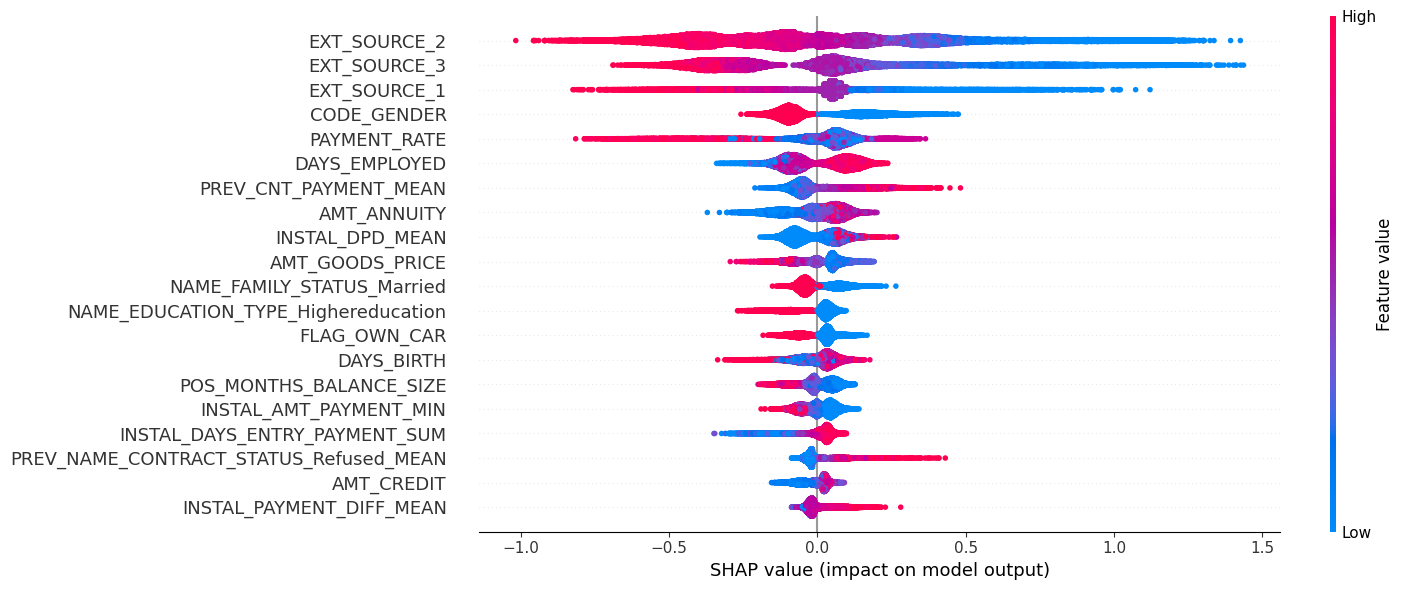

In [57]:
shap.summary_plot(shap_values_pipe[1], X_val_scaled.values, feature_names = X_val_scaled.columns, plot_size=(15,6))

## Local

In [58]:
i = 0
shap.initjs()
display("Individu ID: {}".format(X_val_scaled.index[i]))
shap.force_plot(explainer_pipe.expected_value[1],
                shap_values_pipe[1][i],
                X_val_scaled.values[i],
                feature_names = X_val_scaled.columns)

'Individu ID: 109175'

In [59]:
# ID client
client_id = 109175  
client_index = X_val_scaled.index.get_loc(client_id)
client_shap_values = shap_values_pipe[1][client_index]

shap.initjs()
shap.force_plot(explainer_pipe.expected_value[1], client_shap_values, X_val_scaled.loc[client_id])

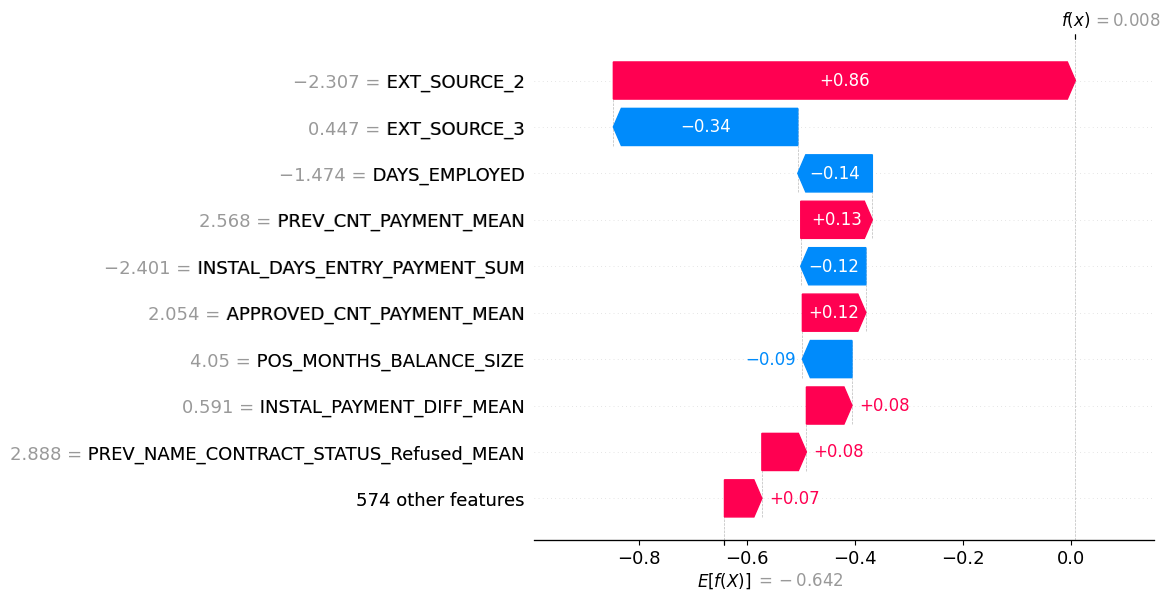

In [60]:
shap.waterfall_plot(explainer_pipe(X_val_scaled)[0][:,1])

In [61]:
# ID client
client_id = 109175  
client_index = X_val_scaled.index.get_loc(client_id)
client_shap_values = shap_values_pipe[1][client_index]

shap.initjs()
shap.force_plot(explainer_pipe.expected_value[1], client_shap_values, X_val_scaled.loc[client_id])

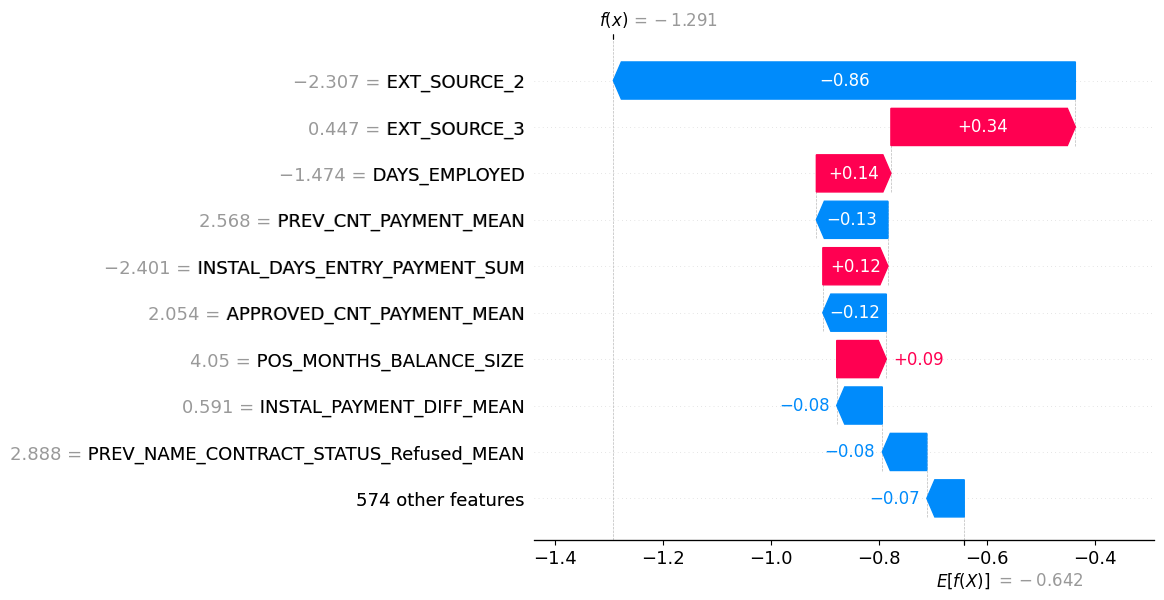

In [62]:
shap_values_for_sample = explainer_pipe.shap_values(X_val_scaled.loc[[109175]])

shap.waterfall_plot(shap.Explanation(values=shap_values_for_sample[0][0], 
                                     base_values=explainer_pipe.expected_value[1], 
                                     data=X_val_scaled.loc[109175], 
                                     feature_names=X_val_scaled.columns))

- En examinant de près les contributions des différentes caractéristiques sur la décision d'un modèle pour un cas spécifique, nous avons vu comment certaines caractéristiques peuvent augmenter ou diminuer la prédiction. Les éléments qui réduisent la prédiction sont montrés en bleu, tandis que ceux qui l'augmentent sont en rouge.
- Par exemple, pour le client avec l'ID 109175, j'ai identifié les deux caractéristiques principales qui influencent fortement sa prédiction.
- Cette analyse  aide à comprendre de manière concrète et précise quelles informations le modèle considère comme importantes pour prendre ses décisions. C'est une façon de rendre les modèles de machine learning plus transparents et compréhensibles, en  montrant ce qui contribue à augmenter ou diminuer les prédictions pour chaque individu.

# Data Drift

- Le "Data Drift" désigne les variations dans les données au fil du temps.
- L'objectif principal de la détection du Data Drift est d'identifier ces changements dans les données de manière précoce pour permettre des ajustements ou une réentrainement du modèle, assurant ainsi que le modèle reste précis et fiable au fil du temps.
- : La détection du Data Drift fonctionne en comparant les statistiques des données récentes (en production) avec celles des données sur lesquelles le modèle a été initialement entraîné. 
- Les écarts significatifs dans ces statistiques signalent un potentiel Data Drift.
- Des outils et techniques comme des tests statistiques, la Distance de Wasserstein pour les données numériques, et la Divergence de Jensen-Shannon pour les données catégorielles sont couramment utilisés pour mesurer et quantifier ces écarts.


In [63]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

In [64]:
df_train  = pd.read_csv("application_train.csv")
df_test   = pd.read_csv("application_test.csv")

model = pickle.load(open("best_model.joblib", "rb"))
shap_values = joblib.load("shap_values.joblib")

In [65]:
reference = df_train[:10000]
reference = reference.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
current = df_test[:10000]

In [66]:
report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference, current_data=current)
report

In [67]:
report.save_html('data_drift_samples.html')